In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
train_data = pd.read_csv("train_values.csv")
train_labels=pd.read_csv("train_labels.csv")
test_data = pd.read_csv("test_values.csv")



### 判斷資料是否有重複值

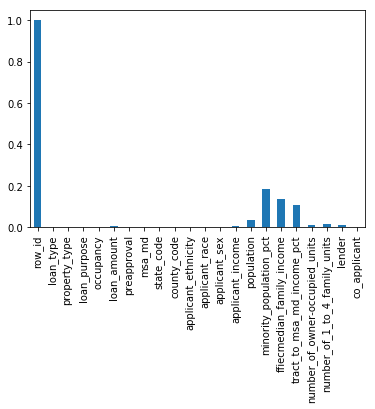

In [7]:
(train_data.apply(lambda x:x.unique().shape[0],axis=0)/train_data.shape[0]).plot(kind='bar')
plt.show()

上圖中，若欄位所對應的y值小，則代表該欄位的值有高度重複的現象。也就是說，該欄位可能為類別型變數。而若y值=1,則代表該欄位無重複值，有可能為索引或是連續型變數。

In [42]:
for i in train_data.columns:
    print(f'{i} : {len(train_data[i].unique())}')

row_id : 500000
loan_type : 4
property_type : 3
loan_purpose : 3
occupancy : 3
loan_amount : 2997
preapproval : 3
msa_md : 409
state_code : 53
county_code : 318
applicant_ethnicity : 4
applicant_race : 7
applicant_sex : 4
applicant_income : 1898
population : 18203
minority_population_pct : 91924
ffiecmedian_family_income : 68869
tract_to_msa_md_income_pct : 54536
number_of_owner-occupied_units : 6089
number_of_1_to_4_family_units : 7375
lender : 6111
co_applicant : 2
accepted : 2


由上圖可知，msa_md, state_code, county_code雖為類別型變數，但項數較多

### 欄位是否有空值？

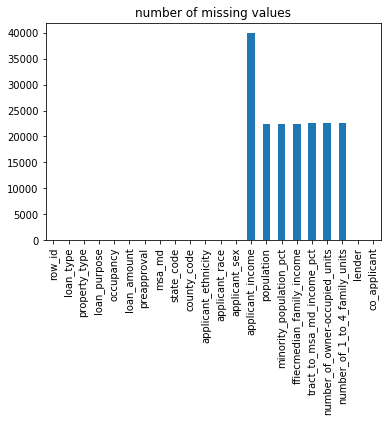

In [10]:
train_data.isnull().sum().plot(kind='bar',title='number of missing values')
plt.show()

由上圖得知，applicamt_income,population,minority_population_pct,tract_to_msa_md_income_pct,number_of_owener_occupied_units和number_of_1_to_4_family_units這幾個欄位含有空值。

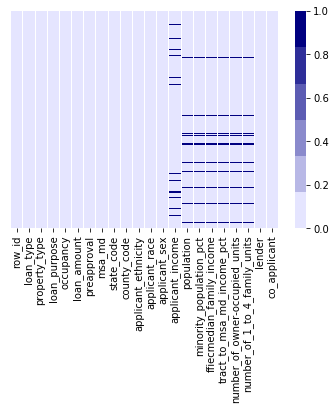

In [15]:
cmap=sns.light_palette("navy", reverse=False)
sns.heatmap(train_data.isnull().astype(np.int8),yticklabels=False,cmap=cmap)
plt.show()

由上圖可知，population,minority_population_pct,tract_to_msa_md_income_pct,number_of_owener_occupied_units和number_of_1_to_4_family_units等欄位的缺失值出現的列數大部分都為相同

In [16]:
train_data=train_data.join(train_labels.set_index("row_id"),on="row_id")

### 將msa_md,stat_code,county_code轉換為核可機率

In [43]:
msa_md = pd.crosstab(index=train_data["msa_md"], columns=train_data["accepted"])
state_code = pd.crosstab(index=train_data["state_code"], columns=train_data["accepted"])
lender = pd.crosstab(index=train_data["lender"], columns=train_data["accepted"])

In [44]:
msa_md_accept_rate=round(msa_md[1]/(msa_md[1]+msa_md[0]),2)
state_accept_rate=round(state_code[1]/(state_code[1]+state_code[0]),2)
lender_accept_rate=round(lender[1]/(lender[1]+lender[0]),2)

In [45]:
lender_accept_rate = pd.DataFrame({'lender':lender_accept_rate.index, 'lender_accept_prob':lender_accept_rate.values})
msa_md_accept_rate = pd.DataFrame({'msa_md':msa_md_accept_rate.index, 'msa_accept_prob':msa_md_accept_rate.values})
state_accept_rate=pd.DataFrame({"state_code":state_accept_rate.index, 'state_accept_prob':state_accept_rate.values})

In [46]:
msa_md_accept_rate.head()

,msa_md,msa_accept_prob
0,-1,0.34
1,0,0.57
2,1,0.48
3,2,0.60
4,3,0.39


In [47]:
#msa_md_accept_rate.set_index('msa_md')
train_data=pd.merge(train_data,msa_md_accept_rate,on="msa_md")
train_data=pd.merge(train_data,state_accept_rate,on="state_code")
train_data=pd.merge(train_data,lender_accept_rate,on="lender")



In [51]:
test_data=pd.merge(test_data,msa_md_accept_rate,on="msa_md")
test_data=pd.merge(test_data,state_accept_rate,on="state_code")
test_data=pd.merge(test_data,lender_accept_rate,on="lender")


In [54]:
test_data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,minority,tract_family_income,msa_accept_prob,state_accept_prob,lender_accept_prob
0,0,2,1,3,1,115.0,3,101,16,276,...,85.780,1874.0,2410.0,3791,True,3768.03344,59950.7842,0.5,0.48,0.79
1,70,2,1,3,1,82.0,3,101,16,313,...,95.468,1633.0,2153.0,3791,False,6171.39952,68040.0436,0.5,0.48,0.79
2,390,2,1,3,1,142.0,3,101,16,297,...,100.000,2302.0,2627.0,3791,False,3579.98132,70320.0000,0.5,0.48,0.79
3,7593,2,1,3,1,193.0,3,101,16,103,...,100.000,2537.0,3001.0,3791,False,2092.56160,71456.0000,0.5,0.48,0.79
4,20191,3,1,3,1,207.0,3,101,16,313,...,72.445,1350.0,2249.0,3791,True,6112.96200,51273.6732,0.5,0.48,0.79


### 計算minority,tract_family_income欄位

In [49]:
train_data['minority']=train_data['minority_population_pct']/100*train_data['population']
test_data['minority']=test_data['minority_population_pct']/100*test_data['population']
train_data['tract_family_income']=train_data['tract_to_msa_md_income_pct']/100*train_data['ffiecmedian_family_income']
test_data['tract_family_income']=test_data['tract_to_msa_md_income_pct']/100*test_data['ffiecmedian_family_income']

In [103]:
total_columns=['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'msa_accept_prob',
       'state_accept_prob', 'lender_accept_prob', 'minority',
       'tract_family_income']
continuos_columns=['loan_amount','applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct','number_of_owner-occupied_units', 
       'number_of_1_to_4_family_units','msa_accept_prob','state_accept_prob', 'lender_accept_prob',
        'minority','tract_family_income',"accepted"]
categorical_columns=['loan_type', 'property_type', 'loan_purpose', 'occupancy','preapproval', 'msa_md', 'state_code', 'county_code','applicant_ethnicity', 'applicant_race', 'applicant_sex','co_applicant', 'lender']
accepted_train=train_data[train_data['accepted']==1]
unaccepted_train=train_data[train_data['accepted']==0]

In [75]:
train_data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,number_of_1_to_4_family_units,lender,co_applicant,accepted,msa_accept_prob,state_accept_prob,lender_accept_prob,minority,tract_family_income,dummy
0,0,3,1,1,1,70.0,3,18,37,246,...,2642.0,4536,False,1,0.51,0.54,0.84,2743.58690,30859.28604,1.0
1,14667,2,1,1,1,216.0,3,18,37,56,...,3526.0,4536,True,1,0.51,0.54,0.84,886.13043,59851.00000,1.0
2,23824,1,1,3,1,595.0,3,18,37,56,...,1731.0,4536,True,0,0.51,0.54,0.84,2672.42976,31936.08972,1.0
3,40634,1,1,1,2,126.0,3,18,37,56,...,2660.0,4536,False,1,0.51,0.54,0.84,330.05254,58995.00000,1.0
4,42003,1,1,1,2,252.0,3,18,37,56,...,2046.0,4536,True,1,0.51,0.54,0.84,3089.68200,54780.38984,1.0


### 整理各個類別型變數
* 上表為接受(藍) 拒絕(紅) 在loan_amount的分布狀況;中表為判斷離群值的分佈狀況;下表為訓練集與測試集之分佈狀況

loan_amount


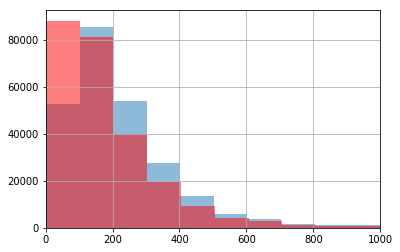

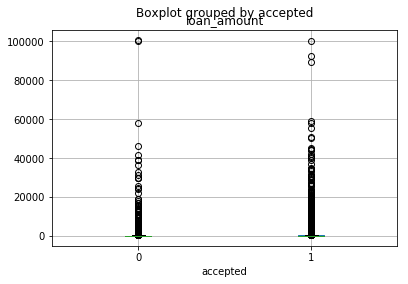

mean: 249.1286053559577 // 194.35273284617784
max: 100333.0 // 100878.0
min: 1.0 // 1.0
median: 184.0 // 141.0


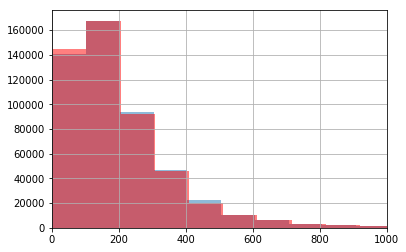

In [77]:
print( 'loan_amount')
accepted_train[  'loan_amount'].hist(bins=1000, alpha=0.5)
unaccepted_train[  'loan_amount'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,1000))
plt.show()

train_data.boxplot(column= 'loan_amount', by='accepted')
train_data[  'loan_amount'].hist(bins=1000, alpha=0.5)
test_data[  'loan_amount'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,1000))
plt.show()



applicant_income


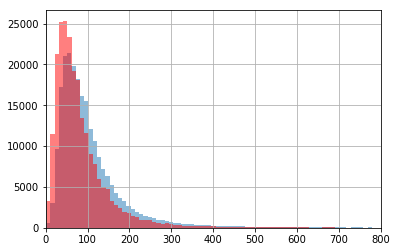

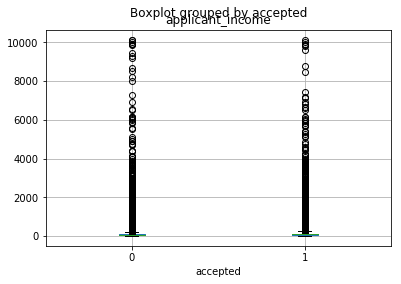

mean: 113.91619164930397 // 90.97127811936153
max: 10109.0 // 10139.0
min: 1.0 // 1.0
median: 83.0 // 64.0


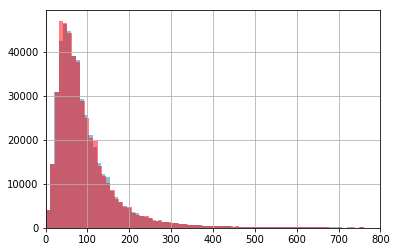

In [57]:
print( 'applicant_income')
accepted_train[ 'applicant_income'].hist(bins=1000, alpha=0.5)
unaccepted_train[  'applicant_income'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,800))
plt.show()

train_data.boxplot(column= 'applicant_income', by='accepted')

plt.show()
print("mean:",accepted_train[ 'applicant_income'].mean(),'//',unaccepted_train[ 'applicant_income'].mean())
print("max:",accepted_train[  'applicant_income'].max(),'//',unaccepted_train[  'applicant_income'].max())
print("min:",accepted_train[  'applicant_income'].min(),'//',unaccepted_train['applicant_income'].min())
print("median:",accepted_train[ 'applicant_income'].median(),'//',unaccepted_train['applicant_income'].median())
train_data[  'applicant_income'].hist(bins=1000, alpha=0.5)
test_data[ 'applicant_income'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,800))
plt.show()

population


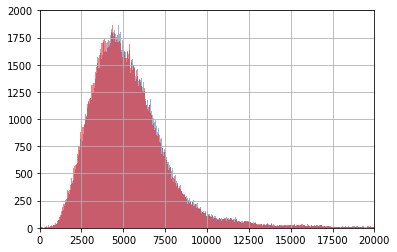

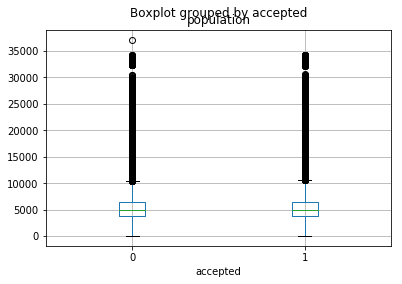

mean: 5466.875374694526 // 5362.21843193245
max: 34176.0 // 37097.0
min: 16.0 // 14.0
median: 5012.0 // 4931.0


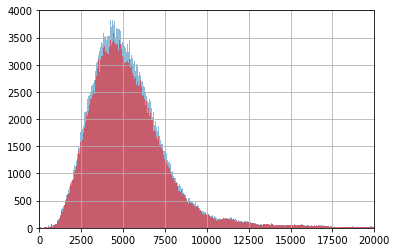

In [58]:
print('population')
accepted_train['population'].hist(bins=1000, alpha=0.5)
unaccepted_train['population'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,20000))
plt.ylim((0,2000))
plt.show()

train_data.boxplot(column= 'population', by='accepted')

plt.show()
print("mean:",accepted_train[ 'population'].mean(),'//',unaccepted_train['population'].mean())
print("max:",accepted_train['population'].max(),'//',unaccepted_train['population'].max())
print("min:",accepted_train['population'].min(),'//',unaccepted_train['population'].min())
print("median:",accepted_train['population'].median(),'//',unaccepted_train['population'].median())

train_data['population'].hist(bins=1000, alpha=0.5)
test_data['population'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,20000))
plt.ylim((0,4000))
plt.show()

minority


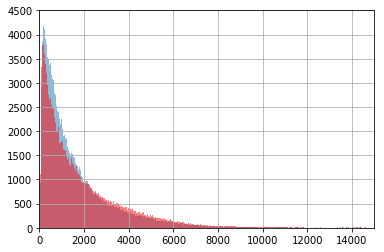

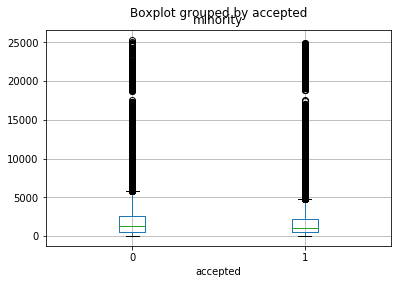

mean: 1666.2867520222123 // 1894.5677945943557
max: 24888.233369999998 // 25349.49978
min: 1.0243799999999998 // 2.9259199999999996
median: 1061.168 // 1226.98845


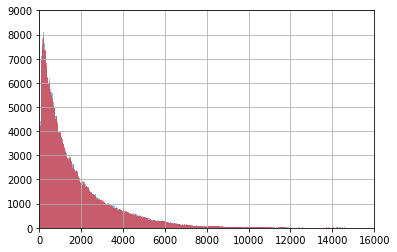

In [59]:
print('minority')
accepted_train['minority'].hist(bins=1000, alpha=0.5)
unaccepted_train['minority'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,15000))
plt.ylim((0,4500))
plt.show()

train_data.boxplot(column='minority', by='accepted')

plt.show()
print("mean:",accepted_train['minority'].mean(),'//',unaccepted_train['minority'].mean())
print("max:",accepted_train['minority'].max(),'//',unaccepted_train['minority'].max())
print("min:",accepted_train['minority'].min(),'//',unaccepted_train['minority'].min())
print("median:",accepted_train['minority'].median(),'//',unaccepted_train['minority'].median())

train_data['minority'].hist(bins=1000, alpha=0.5)
test_data['minority'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,16000))
plt.ylim((0,9000))
plt.show()

minority_population_pct


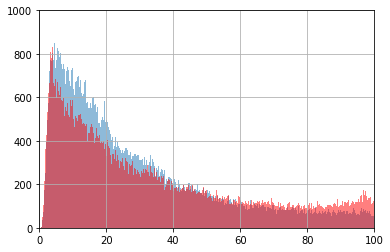

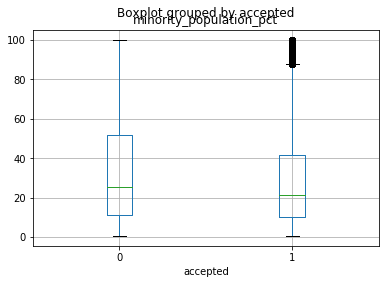

mean: 29.275008049694694 // 34.17370355009384
max: 100.0 // 100.0
min: 0.534 // 0.5379999999999999
median: 21.2045 // 25.221


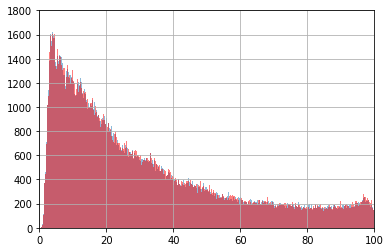

In [60]:
print('minority_population_pct')
accepted_train['minority_population_pct'].hist(bins=1000, alpha=0.5)
unaccepted_train['minority_population_pct'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,100))
plt.ylim((0,1000))
plt.show()

train_data.boxplot(column='minority_population_pct', by='accepted')

plt.show()
print("mean:",accepted_train['minority_population_pct'].mean(),'//',unaccepted_train['minority_population_pct'].mean())
print("max:",accepted_train['minority_population_pct'].max(),'//',unaccepted_train['minority_population_pct'].max())
print("min:",accepted_train['minority_population_pct'].min(),'//',unaccepted_train['minority_population_pct'].min())
print("median:",accepted_train['minority_population_pct'].median(),'//',unaccepted_train['minority_population_pct'].median())


train_data['minority_population_pct'].hist(bins=1000, alpha=0.5)
test_data['minority_population_pct'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,100))
plt.ylim((0,1800))
plt.show()

tract_to_msa_md_income_pct


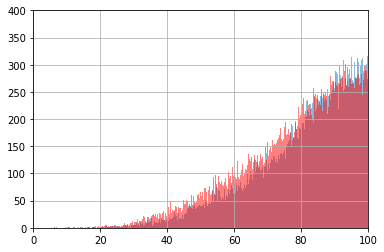

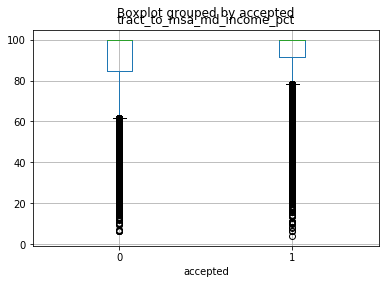

mean: 93.08087172026795 // 90.47022610641785
max: 100.0 // 100.0
min: 3.9810000000000003 // 6.234
median: 100.0 // 100.0


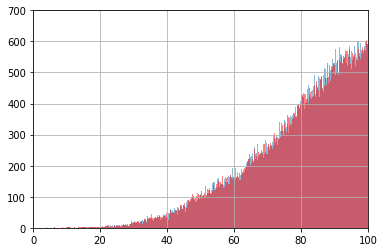

In [61]:
print('tract_to_msa_md_income_pct')
accepted_train['tract_to_msa_md_income_pct'].hist(bins=1000, alpha=0.5)
unaccepted_train['tract_to_msa_md_income_pct'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,100))
plt.ylim((0,400))
plt.show()

train_data.boxplot(column='tract_to_msa_md_income_pct', by='accepted')

plt.show()
print("mean:",accepted_train['tract_to_msa_md_income_pct'].mean(),'//',unaccepted_train['tract_to_msa_md_income_pct'].mean())
print("max:",accepted_train['tract_to_msa_md_income_pct'].max(),'//',unaccepted_train['tract_to_msa_md_income_pct'].max())
print("min:",accepted_train['tract_to_msa_md_income_pct'].min(),'//',unaccepted_train['tract_to_msa_md_income_pct'].min())
print("median:",accepted_train['tract_to_msa_md_income_pct'].median(),'//',unaccepted_train['tract_to_msa_md_income_pct'].median())

train_data['tract_to_msa_md_income_pct'].hist(bins=1000, alpha=0.5)
test_data['tract_to_msa_md_income_pct'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,100))
plt.ylim((0,700))
plt.show()

ffiecmedian_family_income


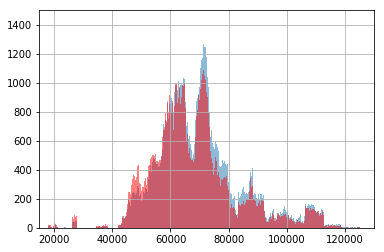

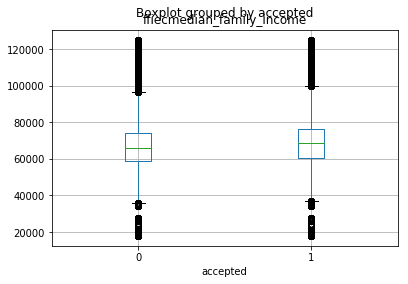

mean: 70184.26590374693 // 68200.20990882098
max: 125248.0 // 125172.0
min: 17858.0 // 17862.0
median: 68843.0 // 65968.0


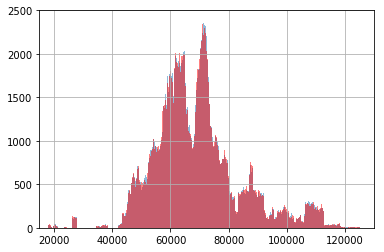

In [62]:
print('ffiecmedian_family_income')
accepted_train['ffiecmedian_family_income'].hist(bins=1000, alpha=0.5)
unaccepted_train['ffiecmedian_family_income'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((15000,130000))
plt.ylim((0,1500))
plt.show()

train_data.boxplot(column='ffiecmedian_family_income', by='accepted')

plt.show()
print("mean:",accepted_train['ffiecmedian_family_income'].mean(),'//',unaccepted_train['ffiecmedian_family_income'].mean())
print("max:",accepted_train['ffiecmedian_family_income'].max(),'//',unaccepted_train['ffiecmedian_family_income'].max())
print("min:",accepted_train['ffiecmedian_family_income'].min(),'//',unaccepted_train['ffiecmedian_family_income'].min())
print("median:",accepted_train['ffiecmedian_family_income'].median(),'//',unaccepted_train['ffiecmedian_family_income'].median())

train_data['ffiecmedian_family_income'].hist(bins=1000, alpha=0.5)
test_data['ffiecmedian_family_income'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((15000,130000))
plt.ylim((0,2500))
plt.show()

tract_family_income


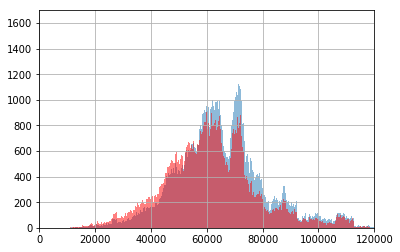

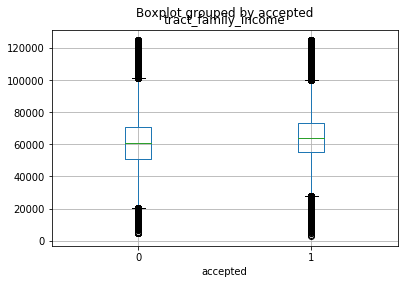

mean: 65226.0817240317 // 61546.97507233526
max: 125248.0 // 125172.0
min: 2930.1354300000003 // 4701.651
median: 64172.0 // 61078.0


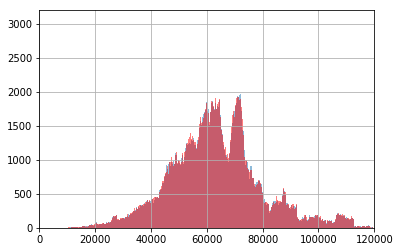

In [63]:
print('tract_family_income')
accepted_train[ 'tract_family_income'].hist(bins=1000, alpha=0.5)
unaccepted_train[ 'tract_family_income'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,120000))
plt.ylim((0,1700))
plt.show()

train_data.boxplot(column='tract_family_income', by='accepted')

plt.show()
print("mean:",accepted_train['tract_family_income'].mean(),'//',unaccepted_train[ 'tract_family_income'].mean())
print("max:",accepted_train['tract_family_income'].max(),'//',unaccepted_train['tract_family_income'].max())
print("min:",accepted_train['tract_family_income'].min(),'//',unaccepted_train['tract_family_income'].min())
print("median:",accepted_train[ 'tract_family_income'].median(),'//',unaccepted_train['tract_family_income'].median())

train_data['tract_family_income'].hist(bins=1000, alpha=0.5)
test_data['tract_family_income'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,120000))
plt.ylim((0,3200))
plt.show()

number_of_owner-occupied_units


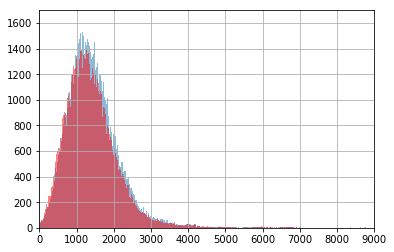

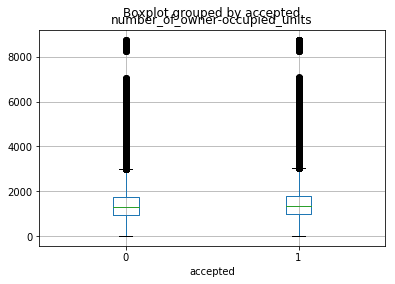

mean: 1453.1532163554928 // 1399.9553600764004
max: 8771.0 // 8761.0
min: 4.0 // 4.0
median: 1350.0 // 1303.0


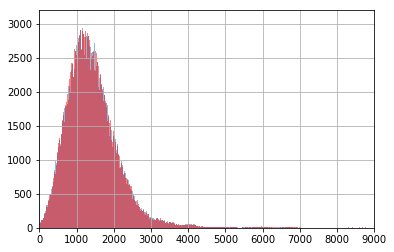

In [64]:
print("number_of_owner-occupied_units")
accepted_train[ 'number_of_owner-occupied_units'].hist(bins=1000, alpha=0.5)
unaccepted_train[ 'number_of_owner-occupied_units'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,9000))
plt.ylim((0,1700))
plt.show()

train_data.boxplot(column='number_of_owner-occupied_units', by='accepted')

plt.show()
print("mean:",accepted_train[ 'number_of_owner-occupied_units'].mean(),'//',unaccepted_train[ 'number_of_owner-occupied_units'].mean())
print("max:",accepted_train[ 'number_of_owner-occupied_units'].max(),'//',unaccepted_train[ 'number_of_owner-occupied_units'].max())
print("min:",accepted_train[ 'number_of_owner-occupied_units'].min(),'//',unaccepted_train[ 'number_of_owner-occupied_units'].min())
print("median:",accepted_train[ 'number_of_owner-occupied_units'].median(),'//',unaccepted_train[ 'number_of_owner-occupied_units'].median())

train_data['number_of_owner-occupied_units'].hist(bins=1000, alpha=0.5)
test_data['number_of_owner-occupied_units'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,9000))
plt.ylim((0,3200))
plt.show()

number_of_1_to_4_family_units


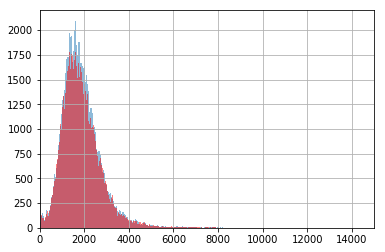

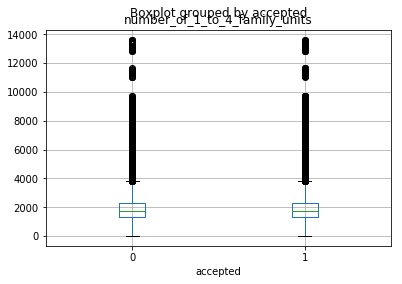

mean: 1891.4209972910605 // 1880.390775093629
max: 13623.0 // 13599.0
min: 1.0 // 1.0
median: 1755.0 // 1751.0


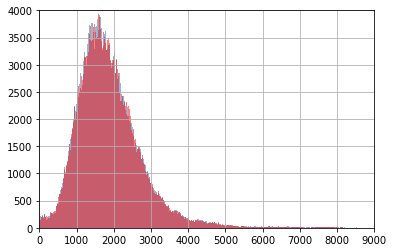

In [65]:
print( 'number_of_1_to_4_family_units')
accepted_train[  'number_of_1_to_4_family_units'].hist(bins=1000, alpha=0.5)
unaccepted_train[  'number_of_1_to_4_family_units'].hist(bins=1000,color='red', alpha=0.5)

plt.xlim((0,15000))
plt.ylim((0,2200))
plt.show()

train_data.boxplot(column= 'number_of_1_to_4_family_units', by='accepted')

plt.show()
print("mean:",accepted_train[  'number_of_1_to_4_family_units'].mean(),'//',unaccepted_train[ 'number_of_1_to_4_family_units'].mean())
print("max:",accepted_train[  'number_of_1_to_4_family_units'].max(),'//',unaccepted_train[  'number_of_1_to_4_family_units'].max())
print("min:",accepted_train[  'number_of_1_to_4_family_units'].min(),'//',unaccepted_train[  'number_of_1_to_4_family_units'].min())
print("median:",accepted_train[  'number_of_1_to_4_family_units'].median(),'//',unaccepted_train[  'number_of_1_to_4_family_units'].median())

train_data['number_of_1_to_4_family_units'].hist(bins=1000, alpha=0.5)
test_data['number_of_1_to_4_family_units'].hist(bins=1000,color='red', alpha=0.5)
plt.xlim((0,9000))
plt.ylim((0,4000))
plt.show()

### 找出連續型變數與accepted欄位 之相關係數

In [104]:
corDf=train_data[continuos_columns].corr()
corDf["accepted"]

loan_amount                       0.046370
applicant_income                  0.074722
population                        0.019163
minority_population_pct          -0.092922
ffiecmedian_family_income         0.066919
tract_to_msa_md_income_pct        0.091766
number_of_owner-occupied_units    0.036029
number_of_1_to_4_family_units     0.006027
msa_accept_prob                   0.175800
state_accept_prob                 0.209597
lender_accept_prob                0.445234
minority                         -0.058975
tract_family_income               0.110813
accepted                          1.000000
Name: accepted, dtype: float64

In [109]:
corDf[abs(corDf["accepted"])>.05]

,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,msa_accept_prob,state_accept_prob,lender_accept_prob,minority,tract_family_income,accepted
applicant_income,0.483951,1.000000,-0.006948,-0.053795,0.114988,0.102667,0.004541,-0.019748,0.064942,0.036719,0.049759,-0.038300,0.158320,0.074722
minority_population_pct,0.007227,-0.053795,0.087383,1.000000,0.021059,-0.442800,-0.214410,-0.157976,-0.001896,-0.137494,-0.069969,0.770633,-0.256885,-0.092922
ffiecmedian_family_income,0.105924,0.114988,-0.014377,0.021059,1.000000,-0.054500,-0.021390,-0.148235,0.543565,0.327942,0.075947,-0.009611,0.779858,0.066919
tract_to_msa_md_income_pct,0.043811,0.102667,0.149677,-0.442800,-0.054500,1.000000,0.360774,0.210613,-0.038840,0.002300,0.051805,-0.212271,0.568395,0.091766
msa_accept_prob,0.061495,0.064942,0.055500,-0.001896,0.543565,-0.038840,0.022471,-0.092854,1.000000,0.520980,0.179880,-0.004905,0.422734,0.175800
state_accept_prob,0.024620,0.036719,-0.065497,-0.137494,0.327942,0.002300,-0.080948,-0.113364,0.520980,1.000000,0.192405,-0.135720,0.268294,0.209597
lender_accept_prob,0.048707,0.049759,0.010341,-0.069969,0.075947,0.051805,0.012237,-0.011007,0.179880,0.192405,1.000000,-0.045865,0.093312,0.445234
minority,0.005519,-0.038300,0.585286,0.770633,-0.009611,-0.212271,0.258390,0.289601,-0.004905,-0.135720,-0.045865,1.000000,-0.141625,-0.058975
tract_family_income,0.114109,0.158320,0.076867,-0.256885,0.779858,0.568395,0.202533,0.005764,0.422734,0.268294,0.093312,-0.141625,1.000000,0.110813
accepted,0.046370,0.074722,0.019163,-0.092922,0.066919,0.091766,0.036029,0.006027,0.175800,0.209597,0.445234,-0.058975,0.110813,1.000000


In [111]:
category_columns=['loan_type', 'property_type', 'loan_purpose', 'occupancy',
        'preapproval', 
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'co_applicant']

### 找出類別型變數之關鍵特徵(類別差異較大)

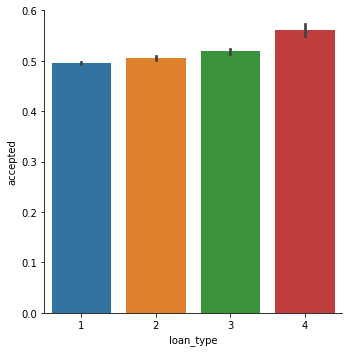

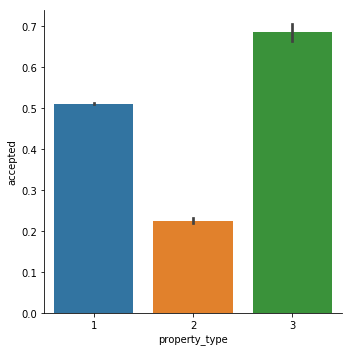

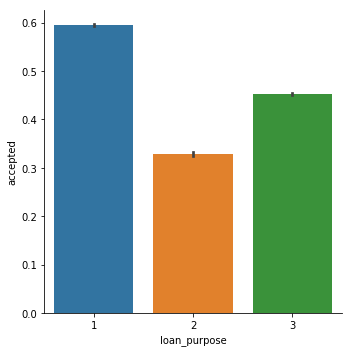

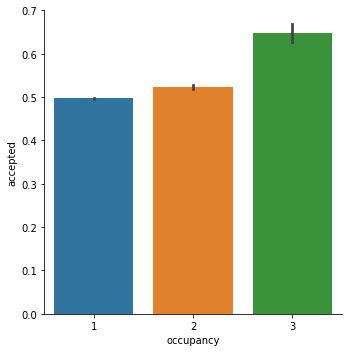

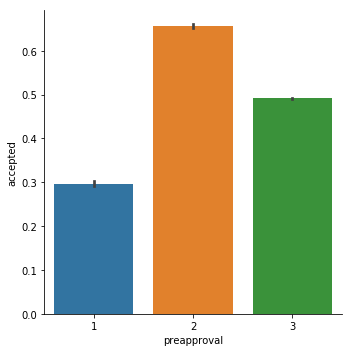

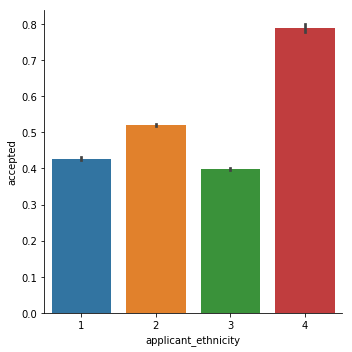

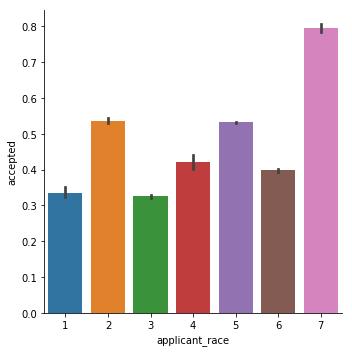

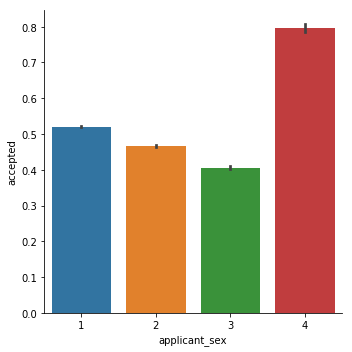

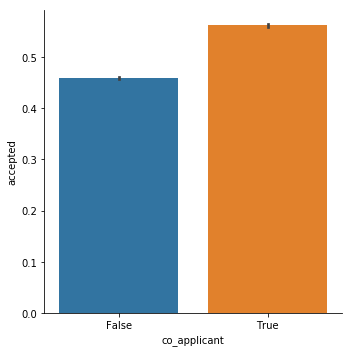

In [115]:
for i in category_columns:
    g=sns.catplot(data=train_data,x=i,y="accepted",kind="bar")
    plt.show()

找出類別型與連續型之關鍵特徵
* 類別型： 'property_type','loan_purpose','occupancy',preapproval','applicant_ethnicity','applicant_race','applicant_sex','co_applicant'
* 連續型：'loan_amount', 'applicant_income', 'population','minority_population_pct', 'ffiecmedian_family_income','tract_to_msa_md_income_pct', 'number_of_owner-occupied_units','number_of_1_to_4_family_units', 'msa_accept_prob', 'state_accept_prob','lender_accept_prob', 'minority', 'tract_family_income'

In [129]:
key_features=['row_id','property_type','loan_purpose','occupancy','preapproval','applicant_ethnicity','applicant_race','applicant_sex','co_applicant','loan_amount', 'applicant_income', 'population','minority_population_pct', 'ffiecmedian_family_income','tract_to_msa_md_income_pct', 'number_of_owner-occupied_units','number_of_1_to_4_family_units', 'msa_accept_prob', 'state_accept_prob','lender_accept_prob', 'minority', 'tract_family_income']
train_kf=train_data[key_features].round(3)
test_kf=test_data[key_features].round(3)

In [132]:
train_kf.co_applicant=train_kf.co_applicant.astype(np.int8)
test_kf.co_applicant=test_kf.co_applicant.astype(np.int8)

In [133]:
train_kf.shape

(500000, 22)

In [134]:
test_kf.shape

(499278, 22)

In [136]:
train_kf.to_csv("train_kf.csv",index=False)
test_kf.to_csv("test_kf.csv",index=False)